<a href="https://colab.research.google.com/github/uplus26e7/pytorch-programming-introduction/blob/master/%E5%8B%95%E3%81%8B%E3%81%97%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6_PyTorch_%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E5%85%A5%E9%96%80_Chapter6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import spacy
import matplotlib.pyplot as plt
import torch
from torchtext import data
from torchtext import datasets
from torch import nn
import torch.nn.functional as F
from torch import optim

# Section 2 感情分析の基本【サンプルコード　】

## Section 2.3 訓練データとテストデータの用意

In [2]:
all_texts = data.Field(tokenize='spacy')
all_labels = data.LabelField(dtype=torch.float)

In [3]:
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

len(train_dataset), len(test_dataset)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 21.7MB/s]


(25000, 25000)

In [4]:
print(vars(train_dataset.examples[0]))

{'text': ['This', 'may', 'just', 'be', 'the', 'most', 'nostalgic', 'journey', 'back', 'in', 'time', '&', 'through', 'time', 'to', 'when', 'one', "'s", 'childhood', 'starts', 'a', 'journey', 'to', 'reminiscences', 'back', '&', 'forth', 'onwards', '&', 'upwards', ',', 'forwards', '&', 'backwards', ',', 'up', '&', 'down', '&', 'all', 'around', '.', 'The', 'boy', 'Jimmy', ',', 'H.R.', 'Puffinstuff', ',', 'Dr', '.', 'Blinky', ',', 'Cling', '&', 'Clang', ',', 'Ludicrous', 'Lion', ',', '&', 'even', 'the', 'evil', 'Witchie', 'Poo', 'too', 'through', '&', 'through', '.', 'The', 'latter', 'day', 'inspirations', 'of', 'Lidsville,"The', 'Brady', 'Kids', 'Saturday', 'Morning', 'Preview', 'Special', '"', 'Sigmund', '&', 'the', 'Sea', 'Monsters', ',', 'and', 'Land', 'of', 'the', 'lost', 'both', 'the', 'new', '&', 'old', 'are', 'what', 'this', 'very', 'show', 'bridged', 'the', 'gap', 'to', 'as', 'well', 'as', 'The', 'Donny', '&', 'Marie', 'Show', ',', 'The', 'Brady', 'Bunch', 'Variety', 'Hour', 'a.k.a

In [5]:
max_vocal_size = 25_000
all_texts.build_vocab(train_dataset, max_size=max_vocal_size)
all_labels.build_vocab(train_dataset)

len(all_texts.vocab), len(all_labels.vocab)

(25002, 2)

In [6]:
all_texts.vocab.freqs.most_common(20)

[('the', 289838),
 (',', 275296),
 ('.', 236843),
 ('and', 156483),
 ('a', 156282),
 ('of', 144055),
 ('to', 133886),
 ('is', 109095),
 ('in', 87676),
 ('I', 77546),
 ('it', 76545),
 ('that', 70355),
 ('"', 63329),
 ("'s", 61928),
 ('this', 60483),
 ('-', 52863),
 ('/><br', 50935),
 ('was', 50013),
 ('as', 43508),
 ('with', 42807)]

In [7]:
all_texts.vocab.itos[:10]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

In [8]:
all_labels.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'neg': 0, 'pos': 1})

In [9]:
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=batch_size,
    device=device
)

for batch in train_batch:
  print(f"text size: {batch.text.size()}")
  print(f"label size: {batch.label.size()}")
  break

text size: torch.Size([965, 64])
label size: torch.Size([64])


## Section 2.4 ニューラルネットワークの定義

In [16]:
class Net(nn.Module):
  def __init__(self, D_in, D_embedding, H, D_out):
    super(Net, self).__init__()
    self.embedding = nn.Embedding(D_in, D_embedding)
    self.lstm = nn.LSTM(D_embedding, H, num_layers=1)
    self.linear = nn.Linear(H, D_out)
  
  def forward(self, x):
    embedded = self.embedding(x)
    output, (hidden, cell) = self.lstm(embedded)
    output = self.linear(output[-1, :, :])
    return output

In [17]:
D_in = len(all_texts.vocab)
D_embedding = 100
H = 256
D_out = 1

net = Net(D_in, D_embedding, H, D_out).to(device)
net

Net(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

## Section 2.5 損失関数と最適化関数の定義

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

## Section 2.6 学習

In [19]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epoch = 10
for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")
  train_loss = 0
  train_accuracy = 0
  test_loss = 0
  test_accuracy = 0

  # train part
  net.train()
  for batch in train_batch:
    texts = batch.text
    labels = batch.label

    optimizer.zero_grad()
    y_pred_prob = net(texts).squeeze(1)
    loss = criterion(y_pred_prob, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
    train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_train_loss = train_loss / len(train_batch)
  epoch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for batch in test_batch:
      texts = batch.text
      labels = batch.label

      y_pred_prob = net(texts).squeeze(1)
      loss = criterion(y_pred_prob, labels)
      test_loss += loss.item()

      y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
      test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_test_loss = test_loss / len(test_batch)
  epoch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {epoch_train_loss:.4f}, Train_Accuracy: {epoch_train_accuracy:.4f}")
  print(f"Test_Loss: {epoch_test_loss:.4f}, Test_Accuracy: {epoch_test_accuracy:.4f}")

  train_loss_list.append(epoch_train_loss)
  train_accuracy_list.append(epoch_train_accuracy)
  test_loss_list.append(epoch_test_loss)
  test_accuracy_list.append(epoch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/10
Train_Loss: 0.6941, Train_Accuracy: 0.5029
Test_Loss: 0.6866, Test_Accuracy: 0.5522
----------------------------------------------------------------------------------------------------
Epoch: 2/10
Train_Loss: 0.6932, Train_Accuracy: 0.5017
Test_Loss: 0.6871, Test_Accuracy: 0.5196
----------------------------------------------------------------------------------------------------
Epoch: 3/10
Train_Loss: 0.6928, Train_Accuracy: 0.4982
Test_Loss: 0.6800, Test_Accuracy: 0.4815
----------------------------------------------------------------------------------------------------
Epoch: 4/10
Train_Loss: 0.6926, Train_Accuracy: 0.4951
Test_Loss: 0.6712, Test_Accuracy: 0.5374
----------------------------------------------------------------------------------------------------
Epoch: 5/10
Train_Loss: 0.6909, Train_Accuracy: 0.5016
Test_Loss: 0.7064, Test_Accuracy: 0.4931
---------------

## Section 2.7 結果の可視化

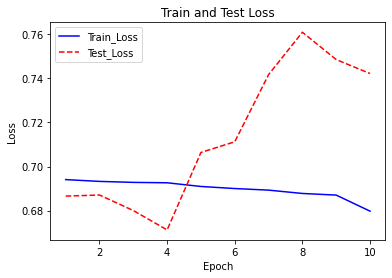

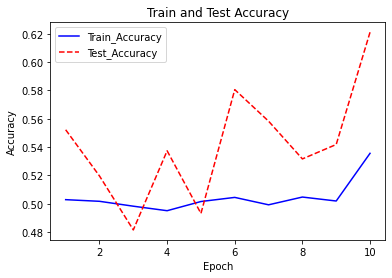

In [22]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch+1), test_loss_list, color='red', linestyle='--', label='Test_Loss')
plt.legend()

plt.figure()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Train_Accuracy')
plt.plot(range(1, epoch+1), test_accuracy_list, color='red', linestyle='--', label='Test_Accuracy')
plt.legend()

plt.show()

# Section 3 感情分析の応用【サンプルコード】

## Section 3.2 訓練データとテストデータの用意

In [24]:
all_texts = data.Field(tokenize="spacy", include_lengths=True)
all_labels = data.LabelField(dtype=torch.float)

In [25]:
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

len(train_dataset), len(test_dataset)

(25000, 25000)

In [26]:
max_vocab_size = 25_000

all_texts.build_vocab(
    train_dataset,
    max_size=max_vocab_size,
    vectors="glove.6B.100d",
    unk_init=torch.Tensor.normal_
)

all_labels.build_vocab(train_dataset)

len(all_texts.vocab), len(all_labels.vocab)

100%|█████████▉| 398589/400000 [00:15<00:00, 25813.87it/s]

(25002, 2)

In [27]:
print(all_texts.vocab.freqs.most_common(20))
print(all_texts.vocab.itos[:10])
print(all_labels.vocab.stoi)

[('the', 289838), (',', 275296), ('.', 236843), ('and', 156483), ('a', 156282), ('of', 144055), ('to', 133886), ('is', 109095), ('in', 87676), ('I', 77546), ('it', 76545), ('that', 70355), ('"', 63329), ("'s", 61928), ('this', 60483), ('-', 52863), ('/><br', 50935), ('was', 50013), ('as', 43508), ('with', 42807)]
['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']
defaultdict(<function _default_unk_index at 0x7fb8bd01bae8>, {'neg': 0, 'pos': 1})


In [28]:
batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=batch_size,
    sort_within_batch=True,
    device=device
)

for batch in train_batch:
  print(f"text size: {batch.text[0].size()}")
  print(f"seq size: {batch.text[1].size()}")
  print(f"label size: {batch.label.size()}")
  break

text size: torch.Size([344, 64])
seq size: torch.Size([64])
label size: torch.Size([64])


## Section 3.3 ニューラルネットワークの定義

In [33]:
class Net(nn.Module):
  def __init__(self, D_in, D_embedding, H, D_out, n_layers, bidirectional, dropout, pad_idx):
    super(Net, self).__init__()
    self.embedding = nn.Embedding(D_in, D_embedding, padding_idx=pad_idx)
    self.lstm = nn.LSTM(
        D_embedding,
        H,
        num_layers=n_layers,
        bidirectional=bidirectional,
        dropout=dropout
    )
    self.linear = nn.Linear(H * 2, D_out)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x, x_lengths):
    embedded = self.dropout(self.embedding(x))
    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, x_lengths)
    packed_output, (hidden, cell) = self.lstm(packed_embedded)

    output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
    hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
    return self.linear(hidden)


In [36]:
D_in = len(all_texts.vocab)
D_embedding = 100
H = 256
D_out = 1
n_layers = 2
bidirectional = True
dropout=0.5
pad_idx = all_texts.vocab.stoi[all_texts.pad_token]

In [61]:
net = Net(
    D_in,
    D_embedding,
    H,
    D_out,
    n_layers,
    bidirectional,
    dropout,
    pad_idx
).to(device)
net, device

(Net(
   (embedding): Embedding(25002, 100, padding_idx=1)
   (lstm): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
   (linear): Linear(in_features=512, out_features=1, bias=True)
   (dropout): Dropout(p=0.5, inplace=False)
 ), device(type='cuda'))

In [62]:
pretrained_embeddings = all_texts.vocab.vectors
pretrained_embeddings.shape

torch.Size([25002, 100])

In [63]:
net.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.7119, -0.9147,  0.6500,  ..., -0.2260,  1.3059,  1.6226],
        [-0.9387, -0.0342,  1.3879,  ..., -0.0255, -0.0368, -1.1419],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.1413, -0.7184,  0.8533,  ...,  0.3553,  0.8598,  0.3467],
        [-0.3562, -0.0575,  1.8366,  ...,  1.1560,  0.8474,  0.4031],
        [ 2.1670,  1.0418,  0.9463,  ..., -0.0976, -0.0370, -1.1120]],
       device='cuda:0')

In [65]:
unk_idx = all_texts.vocab.stoi[all_texts.unk_token]
net.embedding.weight.data[unk_idx] = torch.zeros(D_embedding)
net.embedding.weight.data[pad_idx] = torch.zeros(D_embedding)

net.embedding.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.1413, -0.7184,  0.8533,  ...,  0.3553,  0.8598,  0.3467],
        [-0.3562, -0.0575,  1.8366,  ...,  1.1560,  0.8474,  0.4031],
        [ 2.1670,  1.0418,  0.9463,  ..., -0.0976, -0.0370, -1.1120]],
       device='cuda:0')

## Section 3.4 損失関数と最適化関数の定義

In [66]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

## Section 3.5 学習

In [67]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epoch = 10
for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0
  train_accuracy = 0
  test_accuracy = 0

  # train part
  net.train()
  for batch in train_batch:
    texts, text_lengths = batch.text
    text_lengths = text_lengths.to("cpu")
    labels = batch.label

    optimizer.zero_grad()
    y_pred_prob = net(texts, text_lengths).squeeze(1)
    loss = criterion(y_pred_prob, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
    train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_train_loss = train_loss / len(train_batch)
  epoch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for batch in test_batch:
      texts, text_lengths = batch.text
      text_lengths = text_lengths.to("cpu")
      labels = batch.label

      y_pred_prob = net(texts, text_lengths).squeeze(1)
      loss = criterion(y_pred_prob, labels)
      test_loss += loss.item()

      y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
      test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_test_loss = test_loss / len(test_batch)
  epoch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {epoch_train_loss:.4f}, Train_Accuracy: {epoch_train_accuracy:.4f}")
  print(f"Test_Loss: {epoch_test_loss:.4f}, Test_Accuracy: {epoch_test_accuracy:.4f}")

  train_loss_list.append(epoch_train_loss)
  train_accuracy_list.append(epoch_train_accuracy)
  test_loss_list.append(epoch_test_loss)
  test_accuracy_list.append(epoch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/10
Train_Loss: 0.6185, Train_Accuracy: 0.6499
Test_Loss: 0.6207, Test_Accuracy: 0.5826
----------------------------------------------------------------------------------------------------
Epoch: 2/10
Train_Loss: 0.5013, Train_Accuracy: 0.7588
Test_Loss: 0.3751, Test_Accuracy: 0.8419
----------------------------------------------------------------------------------------------------
Epoch: 3/10
Train_Loss: 0.3951, Train_Accuracy: 0.8269
Test_Loss: 0.3257, Test_Accuracy: 0.8655
----------------------------------------------------------------------------------------------------
Epoch: 4/10
Train_Loss: 0.3022, Train_Accuracy: 0.8776
Test_Loss: 0.2825, Test_Accuracy: 0.8887
----------------------------------------------------------------------------------------------------
Epoch: 5/10
Train_Loss: 0.2550, Train_Accuracy: 0.9002
Test_Loss: 0.2861, Test_Accuracy: 0.8906
---------------

## Section 3.6 結果の可視化

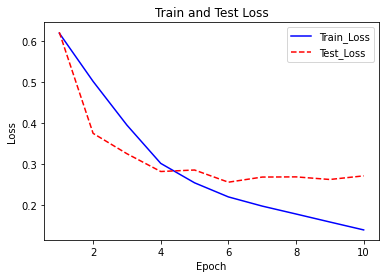

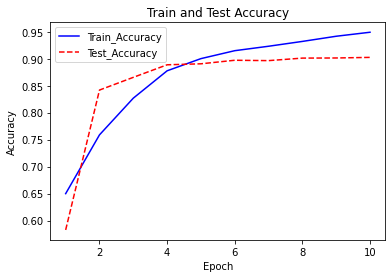

In [68]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch+1), test_loss_list, color='red', linestyle='--', label='Test_Loss')
plt.legend()

plt.figure()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Train_Accuracy')
plt.plot(range(1, epoch+1), test_accuracy_list, color='red', linestyle='--', label='Test_Accuracy')
plt.legend()

plt.show()

## Section 3.7 新しいレビューに対する感情分析

In [69]:
nlp = spacy.load("en")

def predict_sentiment(net, sentence):
  net.eval()
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [all_texts.vocab.stoi[t] for t in tokenized]
  length = [len(indexed)]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(1)
  length_tensor = torch.LongTensor(length)
  prediction = torch.sigmoid(net(tensor, length_tensor))
  return prediction

In [71]:
y_pred_prob = predict_sentiment(net, "This film is terrible")
y_pred_label = torch.round(y_pred_prob)

y_pred_prob.item(), y_pred_label.item()

(0.004626254551112652, 0.0)

In [72]:
y_pred_prob = predict_sentiment(net, "This film is great")
y_pred_label = torch.round(y_pred_prob)

y_pred_prob.item(), y_pred_label.item()

(0.9407355785369873, 1.0)

# Section 4 感情分析の高速化【サンプルコード】

## Section 4.3 訓練データとテストデータの用意

In [73]:
def generate_bigrams(x):
  n_grams = set(zip(*[x[i:] for i in range(2)]))

  for n_gram in n_grams:
    x.append(" ".join(n_gram))
  return x

generate_bigrams(["This", "film", "is", "terrible"])

['This', 'film', 'is', 'terrible', 'is terrible', 'This film', 'film is']

In [74]:
all_texts = data.Field(tokenize="spacy", preprocessing=generate_bigrams)
all_labels = data.LabelField(dtype=torch.float)

In [75]:
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

len(train_dataset), len(test_dataset)

(25000, 25000)

In [76]:
print(vars(train_dataset.examples[0]))

{'text': ['This', 'may', 'just', 'be', 'the', 'most', 'nostalgic', 'journey', 'back', 'in', 'time', '&', 'through', 'time', 'to', 'when', 'one', "'s", 'childhood', 'starts', 'a', 'journey', 'to', 'reminiscences', 'back', '&', 'forth', 'onwards', '&', 'upwards', ',', 'forwards', '&', 'backwards', ',', 'up', '&', 'down', '&', 'all', 'around', '.', 'The', 'boy', 'Jimmy', ',', 'H.R.', 'Puffinstuff', ',', 'Dr', '.', 'Blinky', ',', 'Cling', '&', 'Clang', ',', 'Ludicrous', 'Lion', ',', '&', 'even', 'the', 'evil', 'Witchie', 'Poo', 'too', 'through', '&', 'through', '.', 'The', 'latter', 'day', 'inspirations', 'of', 'Lidsville,"The', 'Brady', 'Kids', 'Saturday', 'Morning', 'Preview', 'Special', '"', 'Sigmund', '&', 'the', 'Sea', 'Monsters', ',', 'and', 'Land', 'of', 'the', 'lost', 'both', 'the', 'new', '&', 'old', 'are', 'what', 'this', 'very', 'show', 'bridged', 'the', 'gap', 'to', 'as', 'well', 'as', 'The', 'Donny', '&', 'Marie', 'Show', ',', 'The', 'Brady', 'Bunch', 'Variety', 'Hour', 'a.k.a

In [77]:
max_vocab_size = 25_000

all_texts.build_vocab(
    train_dataset,
    max_size=max_vocab_size,
    vectors="glove.6B.100d",
    unk_init=torch.Tensor.normal_
)

all_labels.build_vocab(train_dataset)

len(all_texts.vocab), len(all_labels.vocab)

(25002, 2)

In [78]:
all_texts.vocab.freqs.most_common(20)

[('the', 289838),
 (',', 275296),
 ('.', 236843),
 ('and', 156483),
 ('a', 156282),
 ('of', 144055),
 ('to', 133886),
 ('is', 109095),
 ('in', 87676),
 ('I', 77546),
 ('it', 76545),
 ('that', 70355),
 ('"', 63329),
 ("'s", 61928),
 ('this', 60483),
 ('-', 52863),
 ('/><br', 50935),
 ('was', 50013),
 ('as', 43508),
 ('with', 42807)]

In [79]:
all_texts.vocab.itos[:10]

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

In [80]:
all_labels.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'neg': 0, 'pos': 1})

In [81]:
batch_size = 64
device

device(type='cuda')

In [83]:
train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=batch_size,
    device=device
)

for batch in train_batch:
  print(f"text size: {batch.text[0].size()}")
  print(f"seq size: {batch.text[1].size()}")
  print(f"label size: {batch.label.size()}")
  break

text size: torch.Size([64])
seq size: torch.Size([64])
label size: torch.Size([64])


## Section 4.4 ニューラルネットワークの定義

In [84]:
class Net(nn.Module):
  def __init__(self, D_in, D_embedding, D_out, pad_idx):
    super(Net, self).__init__()
    self.embedding = nn.Embedding(D_in, D_embedding, padding_idx=pad_idx)
    self.linear = nn.Linear(D_embedding, D_out)
  
  def forward(self, x):
    embedded = self.embedding(x)
    embedded = embedded.permute(1, 0, 2)
    pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1)
    output = self.linear(pooled)
    return output

In [85]:
D_in = len(all_texts.vocab)
D_embedding = 100
D_out = 1
pad_idx = all_texts.vocab.stoi[all_texts.pad_token]

net = Net(D_in, D_embedding, D_out, pad_idx).to(device)
net

Net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [86]:
pretrained_embeddings = all_texts.vocab.vectors
pretrained_embeddings.shape

torch.Size([25002, 100])

In [87]:
net.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-1.4587, -0.2021,  0.9996,  ..., -1.2870, -0.8841,  0.2154],
        [-1.5164, -1.2080, -0.4500,  ..., -1.5151, -0.9987, -0.2322],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.3951, -1.1500, -0.2021,  ..., -0.1971,  0.2009, -0.2663],
        [ 1.1064, -0.7843,  0.9418,  ..., -0.0850, -0.4145,  0.0315],
        [-0.1274, -0.2584, -0.3060,  ..., -0.0943, -0.0393, -0.1561]],
       device='cuda:0')

In [88]:
unk_idx = all_texts.vocab.stoi[all_texts.unk_token]
net.embedding.weight.data[unk_idx] = torch.zeros(D_embedding)
net.embedding.weight.data[pad_idx] = torch.zeros(D_embedding)

net.embedding.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.3951, -1.1500, -0.2021,  ..., -0.1971,  0.2009, -0.2663],
        [ 1.1064, -0.7843,  0.9418,  ..., -0.0850, -0.4145,  0.0315],
        [-0.1274, -0.2584, -0.3060,  ..., -0.0943, -0.0393, -0.1561]],
       device='cuda:0')

## Section 4.5 損失関数と最適化関数の定義

In [91]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

## Section 4.6 学習

In [94]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epoch = 10
for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0
  train_accuracy = 0
  test_accuracy = 0

  # train part
  net.train()
  for batch in train_batch:
    texts = batch.text
    labels = batch.label

    optimizer.zero_grad()
    y_pred_prob = net(texts).squeeze(1)
    loss = criterion(y_pred_prob, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
    train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_train_loss = train_loss / len(train_batch)
  epoch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for batch in test_batch:
      texts = batch.text
      labels = batch.label

      y_pred_prob = net(texts).squeeze(1)
      loss = criterion(y_pred_prob, labels)
      test_loss += loss.item()

      y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
      test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_test_loss = test_loss / len(test_batch)
  epoch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {epoch_train_loss:.4f}, Train_Accuracy: {epoch_train_accuracy:.4f}")
  print(f"Test_Loss: {epoch_test_loss:.4f}, Test_Accuracy: {epoch_test_accuracy:.4f}")

  train_loss_list.append(epoch_train_loss)
  train_accuracy_list.append(epoch_train_accuracy)
  test_loss_list.append(epoch_test_loss)
  test_accuracy_list.append(epoch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/10
Train_Loss: 0.6796, Train_Accuracy: 0.6324
Test_Loss: 0.5730, Test_Accuracy: 0.7301
----------------------------------------------------------------------------------------------------
Epoch: 2/10
Train_Loss: 0.5988, Train_Accuracy: 0.7814
Test_Loss: 0.4586, Test_Accuracy: 0.7874
----------------------------------------------------------------------------------------------------
Epoch: 3/10
Train_Loss: 0.4945, Train_Accuracy: 0.8387
Test_Loss: 0.3887, Test_Accuracy: 0.8413
----------------------------------------------------------------------------------------------------
Epoch: 4/10
Train_Loss: 0.4119, Train_Accuracy: 0.8715
Test_Loss: 0.3856, Test_Accuracy: 0.8628
----------------------------------------------------------------------------------------------------
Epoch: 5/10
Train_Loss: 0.3541, Train_Accuracy: 0.8903
Test_Loss: 0.4034, Test_Accuracy: 0.8732
---------------

## Section 4.7 結果の可視化

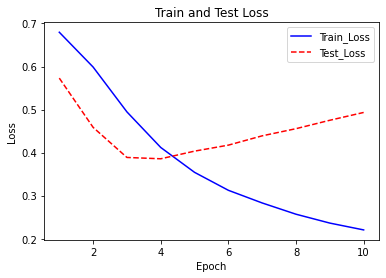

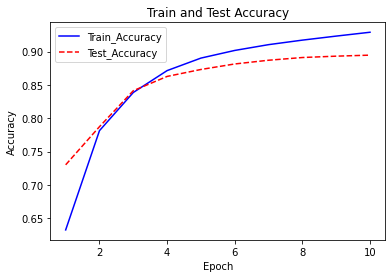

In [95]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch+1), test_loss_list, color='red', linestyle='--', label='Test_Loss')
plt.legend()

plt.figure()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Train_Accuracy')
plt.plot(range(1, epoch+1), test_accuracy_list, color='red', linestyle='--', label='Test_Accuracy')
plt.legend()

plt.show()

In [96]:
nlp = spacy.load("en")

def predict_sentiment(net, sentence):
  net.eval()
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  indexed = [all_texts.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(1)
  prediction = torch.sigmoid(net(tensor))
  return prediction

In [97]:
y_pred_prob = predict_sentiment(net, "This film is terrible")
y_pred_label = torch.round(y_pred_prob)

y_pred_prob.item(), y_pred_label.item()

(0.0, 0.0)

In [98]:
y_pred_prob = predict_sentiment(net, "This film is great")
y_pred_label = torch.round(y_pred_prob)

y_pred_prob.item(), y_pred_label.item()

(1.0, 1.0)

# Section 5 CNNを用いた感情分析【サンプルコード】

## Section 5.2 訓練データとテストデータの用意

In [99]:
all_texts = data.Field(tokenize="spacy", batch_first=True)
all_labels = data.LabelField(dtype=torch.float)

In [100]:
train_dataset, test_dataset = datasets.IMDB.splits(all_texts, all_labels)

In [101]:
max_vocab_size = 25_000
all_texts.build_vocab(
    train_dataset,
    max_size=max_vocab_size,
    vectors="glove.6B.100d",
    unk_init=torch.Tensor.normal_
)

all_labels.build_vocab(train_dataset)

In [103]:
batch_size = 64

train_batch, test_batch = data.BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=batch_size,
    device=device
)

## Section 5.3 ニューラルネットワークの定義

In [104]:
class Net(nn.Module):
  def __init__(self, D_in, D_embedding, n_kernels, kernel_size, D_out, dropout, pad_idx):
    super(Net, self).__init__()
    self.embedding = nn.Embedding(D_in, D_embedding, padding_idx=pad_idx)

    self.conv0 = nn.Conv2d(in_channels=1,
                           out_channels=n_kernels,
                           kernel_size=(kernel_size[0], D_embedding))
    
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=n_kernels,
                           kernel_size=(kernel_size[1], D_embedding))
    
    self.conv2 = nn.Conv2d(in_channels=1,
                           out_channels=n_kernels,
                           kernel_size=(kernel_size[2], D_embedding))
    
    self.linear = nn.Linear(len(kernel_size) * n_kernels, D_out)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, x):
    embedded = self.embedding(x)
    embedded = embedded.unsqueeze(1)

    conved0 = F.relu(self.conv0(embedded).squeeze(3))
    conved1 = F.relu(self.conv1(embedded).squeeze(3))
    conved2 = F.relu(self.conv2(embedded).squeeze(3))

    pooled0 = F.max_pool1d(conved0, conved0.shape[2]).squeeze(2)
    pooled1 = F.max_pool1d(conved1, conved1.shape[2]).squeeze(2)
    pooled2 = F.max_pool1d(conved2, conved2.shape[2]).squeeze(2)

    cat = self.dropout(torch.cat((pooled0, pooled1, pooled2), dim=1))
    output = self.linear(cat)
    return output

In [105]:
D_in = len(all_texts.vocab)
D_embedding = 100
n_kernels = 100
kernel_size = [3, 4, 5]
D_out = 1
dropout=0.5
pad_idx = all_texts.vocab.stoi[all_texts.pad_token]

net = Net(D_in,
          D_embedding,
          n_kernels,
          kernel_size,
          D_out,
          dropout,
          pad_idx).to(device)
net

Net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (conv0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (linear): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [106]:
pretrained_embeddings = all_texts.vocab.vectors
net.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.3835,  2.8597,  0.3658,  ...,  1.5344,  0.4940,  1.0467],
        [ 0.7238,  0.2885,  0.4933,  ..., -0.7712,  2.0372, -1.0866],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.0295,  0.2045,  1.0040,  ..., -0.7419,  0.2499, -1.4894],
        [ 0.5122, -0.3090,  1.4008,  ...,  1.9170, -0.1279, -1.1358],
        [-0.4191, -0.0881, -0.0468,  ...,  2.3983, -0.2747,  0.1161]],
       device='cuda:0')

In [107]:
unk_idx = all_texts.vocab.stoi[all_texts.unk_token]
net.embedding.weight.data[unk_idx] = torch.zeros(D_embedding)
net.embedding.weight.data[pad_idx] = torch.zeros(D_embedding)

net.embedding.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-1.0295,  0.2045,  1.0040,  ..., -0.7419,  0.2499, -1.4894],
        [ 0.5122, -0.3090,  1.4008,  ...,  1.9170, -0.1279, -1.1358],
        [-0.4191, -0.0881, -0.0468,  ...,  2.3983, -0.2747,  0.1161]],
       device='cuda:0')

## Section 5.4 損失関数と最適化関数の定義

In [108]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters())

## Section 5.5 学習

In [109]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

epoch = 10
for i in range(epoch):
  print("-" * 100)
  print(f"Epoch: {i + 1}/{epoch}")

  train_loss = 0
  test_loss = 0
  train_accuracy = 0
  test_accuracy = 0

  # train part
  net.train()
  for batch in train_batch:
    texts = batch.text
    labels = batch.label

    optimizer.zero_grad()
    y_pred_prob = net(texts).squeeze(1)
    loss = criterion(y_pred_prob, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
    train_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_train_loss = train_loss / len(train_batch)
  epoch_train_accuracy = train_accuracy / len(train_batch)

  # eval part
  net.eval()
  with torch.no_grad():
    for batch in test_batch:
      texts = batch.text
      labels = batch.label

      y_pred_prob = net(texts).squeeze(1)
      loss = criterion(y_pred_prob, labels)
      test_loss += loss.item()

      y_pred_labels = torch.round(torch.sigmoid(y_pred_prob))
      test_accuracy += torch.sum(y_pred_labels == labels).item() / len(labels)
  
  epoch_test_loss = test_loss / len(test_batch)
  epoch_test_accuracy = test_accuracy / len(test_batch)

  print(f"Train_Loss: {epoch_train_loss:.4f}, Train_Accuracy: {epoch_train_accuracy:.4f}")
  print(f"Test_Loss: {epoch_test_loss:.4f}, Test_Accuracy: {epoch_test_accuracy:.4f}")

  train_loss_list.append(epoch_train_loss)
  train_accuracy_list.append(epoch_train_accuracy)
  test_loss_list.append(epoch_test_loss)
  test_accuracy_list.append(epoch_test_accuracy)

----------------------------------------------------------------------------------------------------
Epoch: 1/10
Train_Loss: 0.6049, Train_Accuracy: 0.6535
Test_Loss: 0.4302, Test_Accuracy: 0.8056
----------------------------------------------------------------------------------------------------
Epoch: 2/10
Train_Loss: 0.3674, Train_Accuracy: 0.8404
Test_Loss: 0.3341, Test_Accuracy: 0.8548
----------------------------------------------------------------------------------------------------
Epoch: 3/10
Train_Loss: 0.2684, Train_Accuracy: 0.8902
Test_Loss: 0.3164, Test_Accuracy: 0.8646
----------------------------------------------------------------------------------------------------
Epoch: 4/10
Train_Loss: 0.1880, Train_Accuracy: 0.9286
Test_Loss: 0.3212, Test_Accuracy: 0.8670
----------------------------------------------------------------------------------------------------
Epoch: 5/10
Train_Loss: 0.1388, Train_Accuracy: 0.9489
Test_Loss: 0.3468, Test_Accuracy: 0.8661
---------------

## Section 5.6 結果の可視化

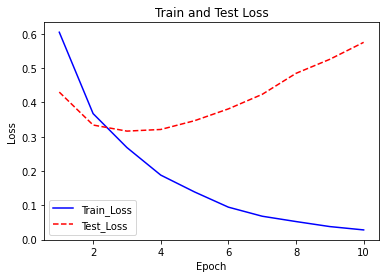

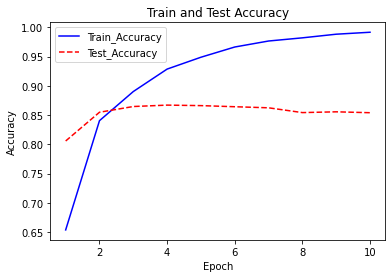

In [110]:
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color="blue", linestyle="-", label="Train_Loss")
plt.plot(range(1, epoch+1), test_loss_list, color='red', linestyle='--', label='Test_Loss')
plt.legend()

plt.figure()
plt.title('Train and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue', linestyle='-', label='Train_Accuracy')
plt.plot(range(1, epoch+1), test_accuracy_list, color='red', linestyle='--', label='Test_Accuracy')
plt.legend()

plt.show()

## Section 5.7 新しいレビューに対する感情分析

In [111]:
nlp = spacy.load("en")

def predict_sentiment(net, sentence, min_len=5):
  net.eval()
  tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
  if len(tokenized) < min_len:
    tokenized += ['<pad>'] * (min_len - len(tokenized))
  
  indexed = [all_texts.vocab.stoi[t] for t in tokenized]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  prediction = torch.sigmoid(net(tensor))
  return prediction

In [112]:
y_pred_prob = predict_sentiment(net, "This film is terrible")
y_pred_label = torch.round(y_pred_prob)

y_pred_prob.item(), y_pred_label.item()

(0.07426921278238297, 0.0)

In [113]:
y_pred_prob = predict_sentiment(net, "This film is great")
y_pred_label = torch.round(y_pred_prob)

y_pred_prob.item(), y_pred_label.item()

(0.9946609139442444, 1.0)